Offensive Win Shares = ((Points Produced) - 0.92(League Points Per Possession)*(Offensive Possessions))/(0.32*(League Points Per Game)*((Team Pace)/(League Pace)))

Defensive Win Shares = ((Player Minutes Played/Team Minutes Played)*(Team Defensive Possessions)*(1.08*(League Points Per Possession)-((Defensive Rating)/100)))/(0.32*(League Points Per Game)*((Team Pace)/(League Pace)))

TOTAL WIN SHARES = OFFENSIVE WIN SHARES + DEFENSIVE WIN SHARES

--------------------------------------------------------------------------------

BASTEBALL POSITIONS AND ROLES:

Point Guard:

Shooting Guard:

Small Forward:

Power Forward:

Center:

--------------------------------------------------------------------------------

1) Predict what position the player is in
    - Multi-Class Classification Problem (5 Choices)

2) Calculate Players Win Shares & Player Efficiency Rating

3) Check what postions the players are...
    - Use token system (Maximum: 5) and subtract 1 for every repetitive position

4) Add Total PER, and Win Shares

5) Create if conditions to see who would win the match


# **IMPORT DEPENDENCIES**

In [0]:
#Data Preprocessing
import pandas as pd

#Produces a prediction model in the form of an ensemble of weak prediction models, typically decision tress
import xgboost as xgb

#The outcome (dependent variable) has only a limited number of possible values.
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression

#A random forest is a meta estimator that fits a number of decision tree classifiers
#on various sub-samples of the dataset and use averaging to improve the predictive
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier

#a discriminative classifier formally defined by a seperating hyperplane.
from sklearn.svm import SVC

#display data
from IPython.display import display

# **DATA EXPLORATION**

In [11]:
data = pd.read_csv('Position_Calculations.csv')

display(data.head())

,Player,Pos,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,FG%,3P%,2P%,eFG%,FT%
0,Alex Abrines,SG,0.144,1.9,7.1,4.5,5.5,1.7,0.6,8.3,15.9,0.393,0.381,0.426,0.531,0.898
1,Quincy Acy,PF,0.353,3.9,18.0,11.0,4.9,1.2,2.0,9.7,16.8,0.412,0.411,0.413,0.521,0.750
2,Steven Adams,C,0.392,13.0,15.5,14.2,5.4,1.8,2.6,16.0,16.2,0.571,0.000,0.572,0.571,0.611
3,Arron Afflalo,SG,0.221,0.7,8.4,4.6,7.4,0.7,0.4,8.4,14.4,0.440,0.411,0.457,0.514,0.892
4,Alexis Ajinca,C,0.225,8.3,23.8,16.0,3.1,1.7,3.1,13.7,17.2,0.500,0.000,0.511,0.500,0.725


In [1]:
n_players = data.shape[0]

n_features = data.shape[1] - 1

print ("Number of Players: {}".format(n_players))
print ("Number of Features: {}".format(n_features))

NameError: ignored

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faeb71c3240>,
      dtype=object)

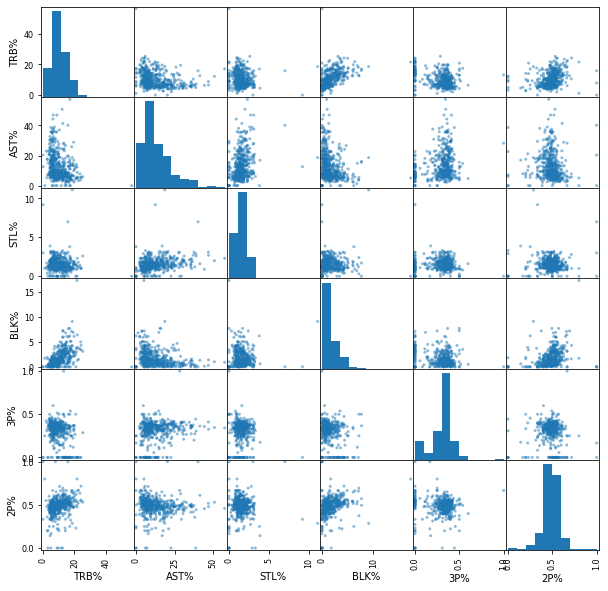

In [13]:
from pandas.plotting import scatter_matrix

scatter_matrix(data[['TRB%','AST%','STL%','BLK%','3P%','2P%']], figsize= (10, 10))

# **PREPARING THE DATA**

In [0]:
#Seperate feature set and target variable
#Pos = Position (PG, SG, PF, SF, C)

X_all = data.drop(['Pos'], 1)
Y_all = data['Pos']

#Standardising the data
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['TRB%', 'AST%', 'STL%', 'BLK%', '3P%', '2P%']]
for col in cols:
  X_all[col] = scale(X_all[col])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 50, random_state = 2, stratify = Y_all)

In [30]:

clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel = 'rbf')
clf_C = xgb.XGBClassifier(seed = 82)


train_predict(X_train, Y_train, X_test, Y_test)
print ('')

train_predict(clf_B, X_train, Y_train, X_test, Y_test)
print ('')

train_predict(clf_C, X_train, Y_train, X_test, Y_test)
print ('')

ImportError: ignored

In [0]:
#DATASET FOR FINDING THE POSITION THE PLAYER IS IN:

#Player (name)
#Pos (Position)
#TS% (True Shooting %)
#3PAr (3-Point Attempt Rate)
#FTr (Free Throw Rate)
#ORB% (Offensive Rebound Percentage)
#DRB% (Defensive Rebound Percentage)
#TRB% (Total Rebound Percentage)
#AST% (Assist Percentage)
#STL% (Steal Percentage)
#BLK% (Block Percentage)
#TOV% (Turnover Percentage)
#USG% (Usage Percentage)
#FG% (Field Goal Percentage)
#3P% (3-Point Field Goal Percentage)
#2P% (2-Point Field Goal Percentage)
#eFG% (Effective Field Goal Percentage)
#FT% (Free Throw Percentage)

#-------------------------------------------------------------------------------------------

#DATASET FOR CALCULATING WIN SHARES, PER, AND OVERALL EFFICIENCY FOR EACH INDIVIDUAL PLAYER:

#Player (name)
#Pos (Position)
#G (Games)
#GS (Games Started)
#MP (Minutes Played)
#PER (Player Efficiency Rating)
#TS% (True Shooting %)
#3PAr (3-Point Attempt Rate)
#FTr (Free Throw Rate)
#ORB% (Offensive Rebound Percentage)
#DRB% (Defensive Rebound Percentage)
#TRB% (Total Rebound Percentage)
#AST% (Assist Percentage)
#STL% (Steal Percentage)
#BLK% (Block Percentage)
#TOV% (Turnover Percentage)
#USG% (Usage Percentage)
#OWS (Offensive Win Shares)
#DWS (Defensive Win Shares)
#WS (Win Shares)
#WS/48 (Win Shares Per 48 Minutes)
#OBPM (Offensive Box Plus/Minus)
#DBPM (Defensive Box Plus/Minus)
#BPM (Box Plus/Minus)
#VORP (Value Over Replacement)
#FG (Field Goals)
#FGA (Field Goal Attempts)
#FG% (Field Goal Percentage)
#3P (3-Point Field Goals)
#3PA (3-Point Field Goal Attempts)
#3P% (3-Point Field Goal Percentage)
#2P (2-Point Field Goals)
#2PA (2-Point Field Goal Attempts)
#2P% (2-Point Field Goal Percentage)
#eFG% (Effective Field Goal Percentage)
#FT (Free Throws)
#FTA (Free Throw Attempts)
#FT% (Free Throw Percentage)
#ORB (Offensive Rebounds)
#DRB (Defensive Rebounds)
#TRB (Total Rebounds)
#AST (Assists)
#STL (Steals)
#BLK (Blocks)
#TOV (Turnovers)
#PF (Personal Fouls)
#PTS (Points)